## Load Inputs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import cromwell_manager as cwm
from google.cloud import storage
import glob
from collections import defaultdict
from scsequtil.plot import grid
from operator import itemgetter
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

In [15]:
google_project = 'your_project'
cromwell_url = 'http://localhost:port_number'

## Configure Cloud Entities

Configure a connection to a locally initiated version of cromwell (version >= 29) and the google project. You will likely have to authenticate independently to enable access to your google storage. 

In [5]:
local_config = {'cromwell_url': cromwell_url}
cromwell = cwm.Cromwell(**local_config)
cromwell.server_is_running()

True

In [6]:
client = storage.Client(project=google_project)

## Set up testing workflows

in the [cromwell_manager](https://github.com/ambrosejcarr/cromwell-manager.git) repository are four WDL files pointing to google storage locations that each contain a different number of fastq reads: 10,000, 100,000, 1,000,000, and 10,000,000. We will use a monitoring script to run each of these workflows, and then calculate the resource usage (memory and disk) of each file throughout each of the run tasks

In [14]:
input_files = [
    'https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/cromwell_manager/test/data/10x_count_inputs_1e4.json',
    'https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/cromwell_manager/test/data/10x_count_inputs_1e5.json',
    'https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/cromwell_manager/test/data/10x_count_inputs_1e6.json',
    'https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/cromwell_manager/test/data/10x_count_inputs_1e7.json'
]
wdl = 'https://raw.githubusercontent.com/HumanCellAtlas/skylab/master/10x/count/count.wdl'
options = 'https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/accessories/options.json'
memory_test_workflows = []
for i in input_files:
    memory_test_workflows.append(cwm.Workflow.from_submission(wdl, i, cromwell, client, options_json=options))
    print(memory_test_workflows[-1].status)

{'status': 'Submitted', 'id': '0583904a-2ed8-477d-bdf0-c2f54f91d59f'}
{'status': 'Running', 'id': '78938d7f-d509-4bfb-a0a6-5bff9413ceb0'}
{'status': 'Submitted', 'id': 'd805dba0-8f12-40e3-9a62-641e94bdeeb5'}
{'status': 'Submitted', 'id': '38338402-ab53-4dff-a2bb-441ee8470a0c'}


In [4]:
for workflow in memory_test_workflows:
    workflow.wait_until_complete()

The above function just checks that the runs are in a terminal state. Below we check that each of the runs have *successfully* completed. 

In [12]:
for w in memory_test_workflows:
    print(w.status)

{'status': 'Succeeded', 'id': '74e00c0a-ffb8-4e1a-94db-b0169ca7ed42'}
{'status': 'Succeeded', 'id': '10be2514-9f6b-4e7f-a443-4f342880fc64'}
{'status': 'Succeeded', 'id': '9fdb2e27-d915-43e9-963e-65b01f0ed9db'}
{'status': 'Succeeded', 'id': 'c17748ac-4620-45d8-959c-2c6e80bcb400'}


Parse each of the resource utilization for each task, then display the tasks for the first workflow. 

In [13]:
# get memory utilization
for t in memory_test_workflows:
    t.tasks(retrieve=True)

# display the run tasks
memory_test_workflows[0].tasks(retrieve=False)

{'count.align_reads_main': <cromwell_tools.task.Task at 0x10ba13ef0>,
 'count.align_reads_split': <cromwell_tools.task.Task at 0x10a7c4860>,
 'count.attach_bcs_and_umis_join': <cromwell_tools.task.Task at 0x10ba1ec50>,
 'count.attach_bcs_and_umis_main': <cromwell_tools.task.Task at 0x10ba13f28>,
 'count.bucket_by_bc_main': <cromwell_tools.task.Task at 0x10ba13828>,
 'count.bucket_by_bc_split': <cromwell_tools.task.Task at 0x10ba1eb00>,
 'count.chunk_reads_join': <cromwell_tools.task.Task at 0x10ba13630>,
 'count.chunk_reads_main': <cromwell_tools.task.Task at 0x10b8540b8>,
 'count.chunk_reads_split': <cromwell_tools.task.Task at 0x10b9fab70>,
 'count.count_genes_join': <cromwell_tools.task.Task at 0x10b9fa9b0>,
 'count.count_genes_main': <cromwell_tools.task.Task at 0x10ba13f60>,
 'count.count_genes_split': <cromwell_tools.task.Task at 0x10ba1ed68>,
 'count.extract_reads_join': <cromwell_tools.task.Task at 0x10ba1e438>,
 'count.extract_reads_main': <cromwell_tools.task.Task at 0x10a7c4

Now group the tasks across the four experiments so we have a dictionary with four values for each task.

In [18]:
aggregated = defaultdict(list)
for size, w in zip([1e4, 1e5, 1e6, 1e7], memory_test_workflows):
    for task_name, task in w.tasks(retrieve=False).items():
        aggregated[task_name].append([size, task.resource_utilization])

## Memory Usage by Task

Write two scripts to: 

- Calculate the linear equation that describes the relationship between the input data size `x` and the memory used. 
  - Below, we can see that after we fit an intercept (a baseline required amount of memory for a task) most of the tasks are not dependent upon the input size, suggesting that the task is dealing the the data sequentially, rather than loading it into memory. This is good!
- Display the relationship on the same axes, displaying which tasks have the highest memory usage. 

In [28]:
# calculate the memory usage equation (fit linear function)
def calculate_input_size_to_attribute_relationship(attribute, aggregated_tasks, name=None, *args, **kwargs):
    task_data = {}
    for task_name, results in sorted(aggregated_tasks.items(), key=itemgetter(0)):
        sizes, results = zip(*sorted(results, key=itemgetter(0)))
        usage = [getattr(r, attribute) for r in results]

        # regression inputs
        sizes = np.log(np.array(list(sizes))[:, None])
        usage = np.log(np.array(usage)[:, None])
        
        # run the regression
        lr = LinearRegression(*args, **kwargs)
        lr.fit(sizes, usage)
        b = np.ravel(np.exp(lr.intercept_))[0]  # intercept provides basic memory
        m = np.ravel(lr.coef_)[0]  # first coefficient provides slope of line
        task_data[task_name] = '{b:.2f} + {m:.2f}*x'.format(b=b, m=m)
    result = pd.Series(task_data)
    result.name = name
    return result

In [24]:
calculate_input_size_to_attribute_relationship(
    attribute='max_memory', aggregated_tasks=aggregated, name='10x count memory usage')

count.align_reads_main            1245.33 + 0.03*x
count.align_reads_split           320.07 + -0.01*x
count.attach_bcs_and_umis_join     233.52 + 0.11*x
count.attach_bcs_and_umis_main     111.81 + 0.15*x
count.bucket_by_bc_main              1.66 + 0.50*x
count.bucket_by_bc_split           257.90 + 0.01*x
count.chunk_reads_join            301.89 + -0.00*x
count.chunk_reads_main             252.58 + 0.01*x
count.chunk_reads_split            285.28 + 0.00*x
count.count_genes_join             376.07 + 0.04*x
count.count_genes_main             159.43 + 0.09*x
count.count_genes_split            256.65 + 0.01*x
count.extract_reads_join           496.16 + 0.00*x
count.extract_reads_main           543.31 + 0.00*x
count.extract_reads_split         277.94 + -0.00*x
count.filter_barcodes              347.87 + 0.04*x
count.mark_duplicates_join         227.55 + 0.02*x
count.mark_duplicates_main         203.83 + 0.04*x
count.mark_duplicates_split        268.63 + 0.00*x
count.setup_chunks             

In [ ]:
# visualize the results
def plot_attribute(attribute):
    nplots = len(aggregated)
    # make some scatter plots with the amounts vs input sizes
    ag = grid.AxesGrid(nplots, figsize=(20, 20), sharex=True, sharey=True)


    def plot_function(x, y, dependent_var, ax):
        ax.loglog(
            x, y, c='royalblue', marker='o', markersize=10,
            markerfacecolor='indianred')
        ax.set_xlabel('input_size')
        ax.set_ylabel(dependent_var)

    # build argument groups
    args = []
    for task_name, results in sorted(aggregated.items(), key=itemgetter(0)):
        sizes, results = zip(*sorted(results, key=itemgetter(0)))
        usage = [getattr(r, attribute) for r in results]
        args.append((sizes, usage, task_name))

    ag.plot_all(args, plot_function)
    plt.tight_layout()
    return ag

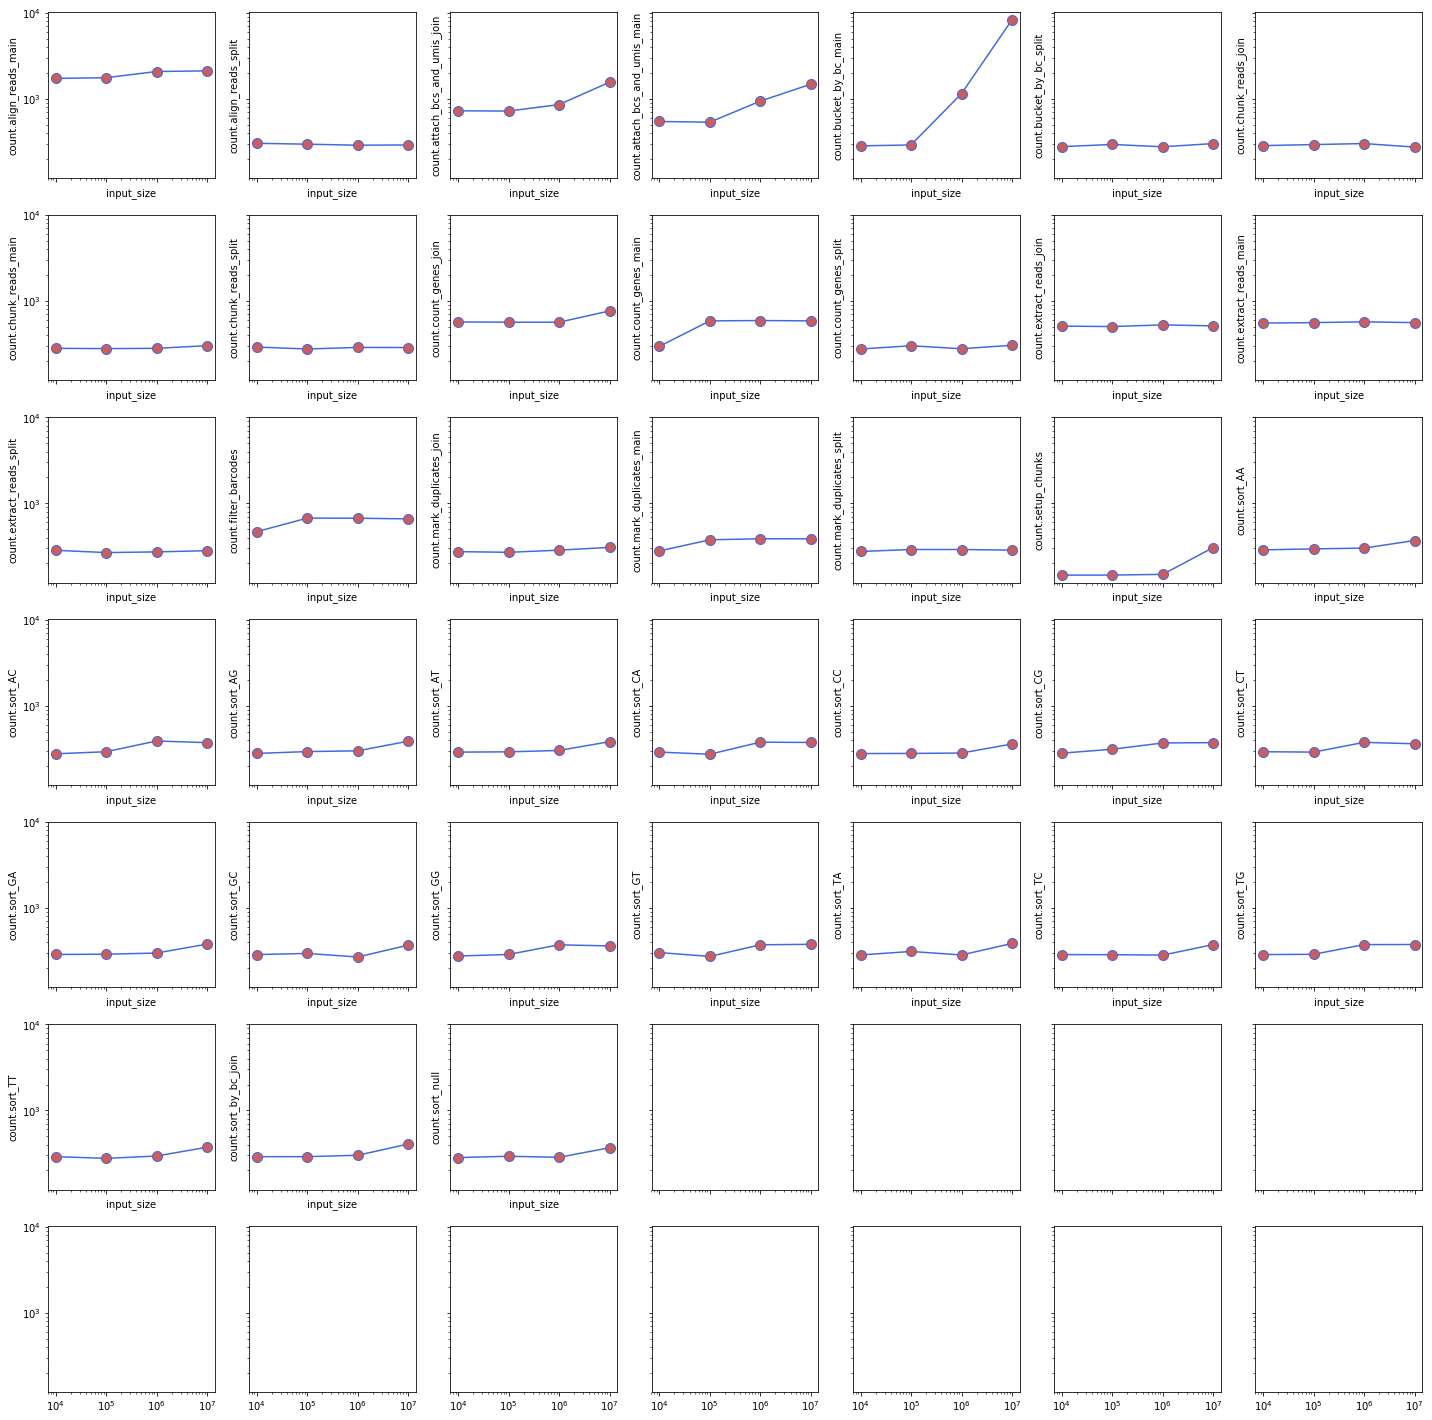

In [25]:
ag = plot_attribute('max_memory')
plt.savefig('memory_utilization.png', dpi=150)  # save the result

## Disk Usage by Task

Write two scripts to: 

- Calculate the linear equation that describes the relationship between the input data size `x` and the disk used, with the important distinction that this time we don't fit an intercept, as baseline memory utilization should relate to the input quantity. 
  - Below, we can see that each task essentially doubles the input, suggesting that most tasks are writing a duplicate version of the data (whose size is approximately equivalent), presumably containing modifications made by the task. 
- Display the relationship on the same axes, displaying which tasks have the highest disk usage. 

In [29]:
calculate_input_size_to_attribute_relationship(
    attribute='max_disk', aggregated_tasks=aggregated, name='10x count disk usage', fit_intercept=False)

count.align_reads_main            1.00 + 1.10*x
count.align_reads_split           1.00 + 1.04*x
count.attach_bcs_and_umis_join    1.00 + 1.08*x
count.attach_bcs_and_umis_main    1.00 + 1.08*x
count.bucket_by_bc_main           1.00 + 0.95*x
count.bucket_by_bc_split          1.00 + 0.95*x
count.chunk_reads_join            1.00 + 0.83*x
count.chunk_reads_main            1.00 + 1.01*x
count.chunk_reads_split           1.00 + 0.83*x
count.count_genes_join            1.00 + 0.94*x
count.count_genes_main            1.00 + 1.08*x
count.count_genes_split           1.00 + 1.08*x
count.extract_reads_join          1.00 + 1.02*x
count.extract_reads_main          1.00 + 1.02*x
count.extract_reads_split         1.00 + 0.83*x
count.filter_barcodes             1.00 + 0.93*x
count.mark_duplicates_join        1.00 + 0.95*x
count.mark_duplicates_main        1.00 + 1.08*x
count.mark_duplicates_split       1.00 + 0.95*x
count.setup_chunks                1.00 + 0.94*x
count.sort_AA                     1.00 +

This is a nice easy conclusion; For the 10x count WDL, the disk request should be approximately the size of the inputs * 2.5 (including 20% additional space to be safe). 

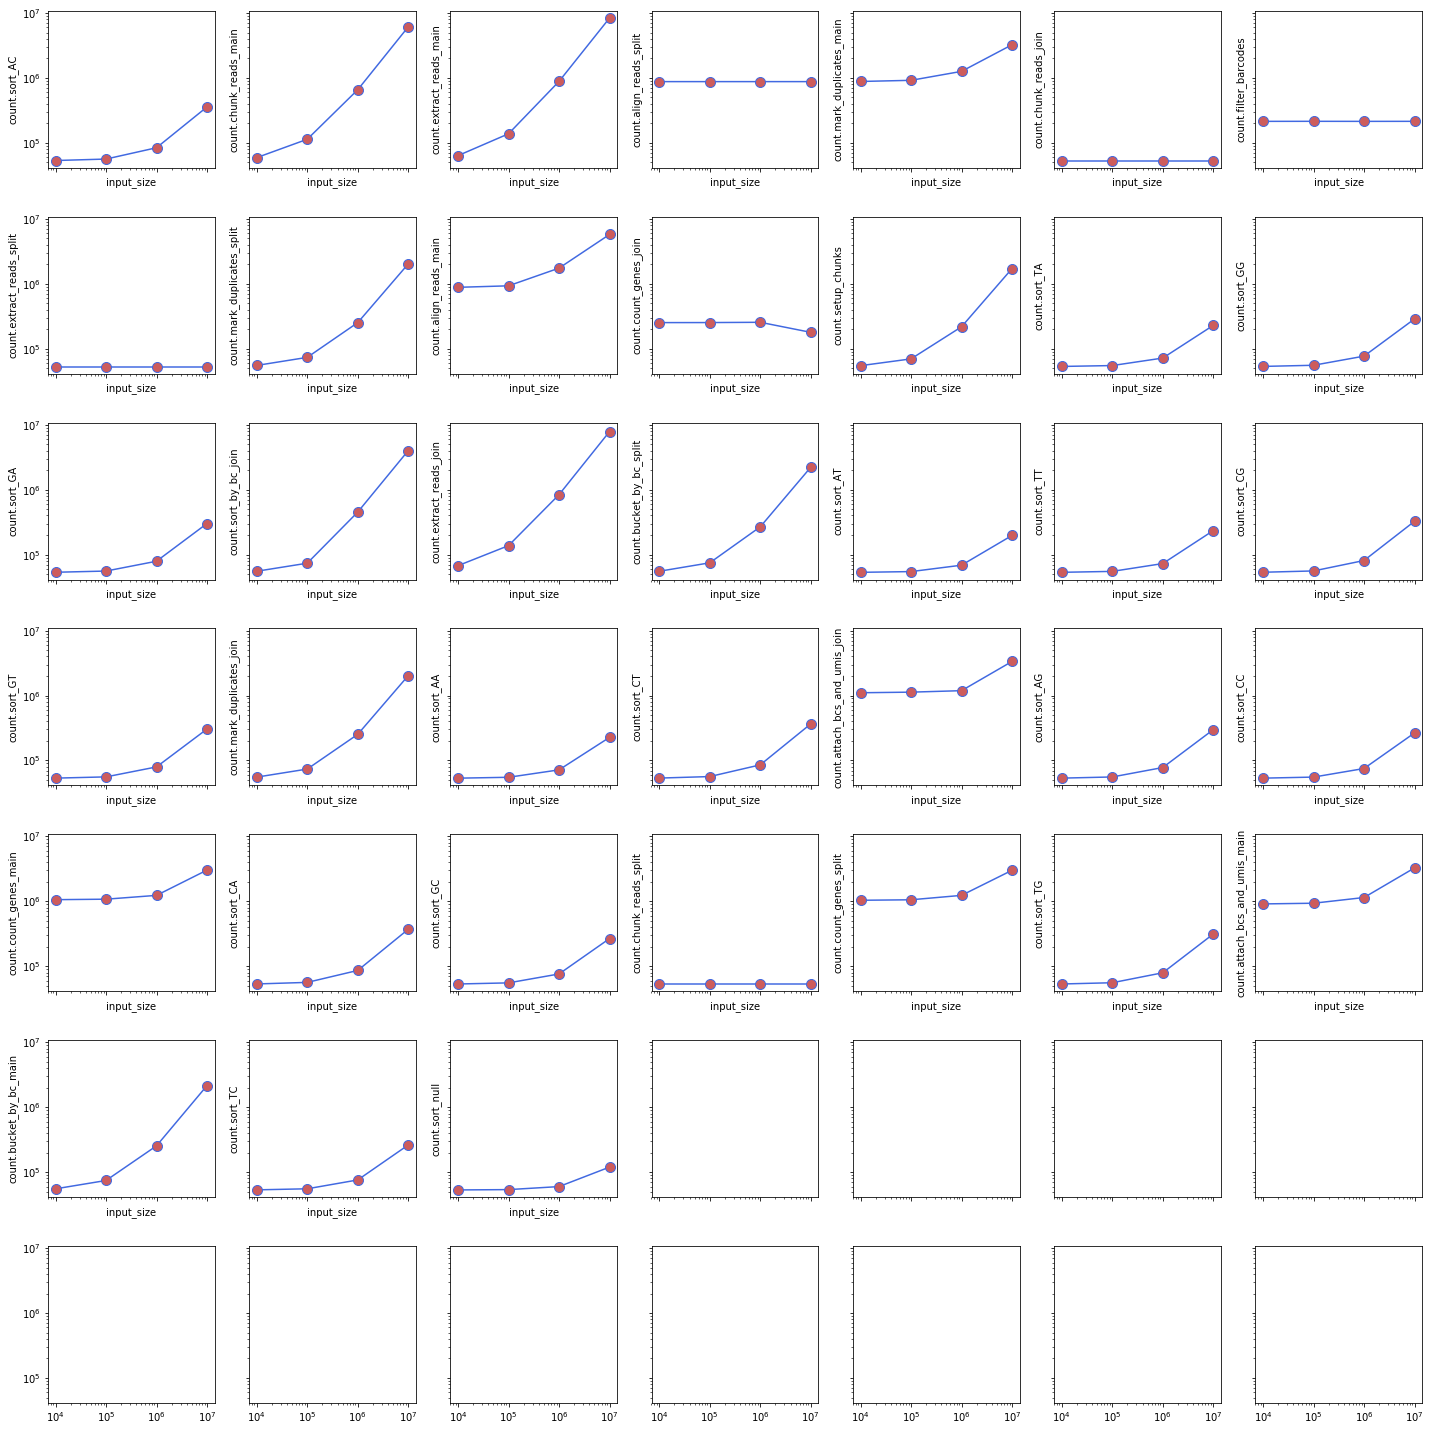

In [109]:
# display disk usage
ag = plot_attribute('max_disk')
plt.savefig('disk_utilization.png', dpi=150)